<a href="https://colab.research.google.com/github/tom-schoener/ml-probability/blob/master/tfp-evaluation/notebooks/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MCMC

In [0]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options(enable_gpu_ram_resizing=True, enable_xla=False)
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

# Probabilistic Models

using the Hamiltonain algorithm: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo

The generated data is based on the following idea:

A factory produces a good amount of product every day. A few of them have missing parts or are broken but this amount varies. They keep a list of the amount of broken products. After an to us unknown amount of days an inspection takes place which results in fewer broken products. Using an MCMC algorithm we should be able to predict the day of inspection.

In [2]:
# generate data
n_checks = 250
n_faults = 55
n_tests = 600
inspection_day = int(n_tests * 0.65)
n_faults_after_inspection = 53

data = []
for i in range(n_tests):
  if i == inspection_day:
    n_faults = n_faults_after_inspection
  probs = n_faults/n_checks
  data += [tfd.Bernoulli(probs=n_checks * [probs]).sample()]

data = tf.reduce_sum(data, 1)
data_ = evaluate(data)

print(data_)
print("Inspection day (unknown to us): " + str(inspection_day))

[50 49 58 62 50 51 55 53 55 52 56 42 49 55 45 65 56 55 60 44 45 44 47 56
 68 48 61 50 57 45 51 55 65 60 62 49 53 47 48 64 58 55 53 58 42 55 61 60
 58 66 64 60 60 62 54 55 53 57 58 52 52 58 53 45 60 55 54 47 50 51 56 59
 53 64 60 72 49 45 65 64 60 57 53 54 61 65 51 43 56 56 59 63 56 61 57 59
 54 56 60 61 64 46 54 46 53 47 55 46 54 61 51 54 53 61 64 62 50 54 54 46
 50 62 50 58 60 58 56 61 51 57 75 60 63 56 54 58 57 55 53 56 57 47 51 62
 69 65 43 58 54 65 62 57 46 45 51 50 54 52 52 60 60 57 56 62 64 61 56 51
 60 55 50 51 62 57 60 76 54 58 58 52 60 56 61 54 73 55 49 59 56 56 48 54
 43 55 48 61 50 56 47 59 46 57 42 59 54 53 56 42 62 59 56 57 55 71 55 60
 55 60 55 49 58 55 61 50 64 53 53 51 54 43 50 51 58 46 53 47 46 55 55 51
 57 54 52 54 58 53 55 65 46 49 48 60 49 56 54 52 48 53 43 63 62 57 53 67
 55 62 53 60 68 42 51 61 45 55 49 50 50 41 60 60 57 69 65 46 48 46 62 52
 58 54 54 58 55 47 54 39 51 65 55 47 65 52 51 56 52 55 58 41 56 51 66 44
 47 53 63 61 51 49 42 57 49 63 60 70 61 48 63 58 58

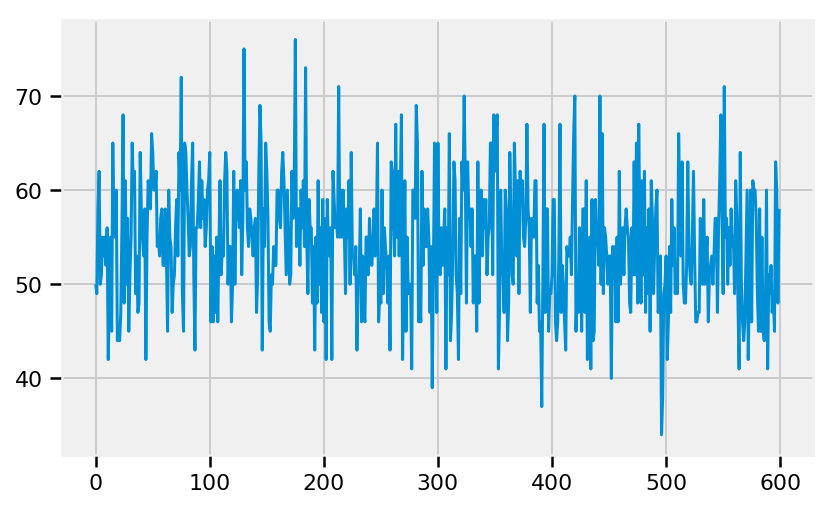

In [3]:
# plot data
X = np.arange(data_.shape[0])
plt.plot(X, data_)

**Exponential function**

![Exponentail Funktion](http://mathworld.wolfram.com/images/interactive/ExpReal.gif)

**Sigmoid**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png)

**Exponential  distribution (PDF)**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/325px-Exponential_pdf.svg.png)

**Poisson distribution (PDF)**

![Exponentail Funktion](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/325px-Poisson_pmf.svg.png)

---


**Model**

```
Day of inspection
τ ~ Uniform()

Parameter of the posterior distribution
α = 1 / mean(data) 
λ1 ~ Exp(α)
λ2 ~ Exp(α)

Result (posterior distribution)
λ(day) = iff (day < τ) then λ1 else λ2
observation(day) ~ Poisson(λ(day))
```

3 unknown variables/ dimensions: λ1, λ2,  τ

In [0]:
# Set the chain's start state.
initial_chain_state = [
  tf.cast(tf.reduce_mean(data), dtype=tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
  tf.cast(tf.reduce_mean(data), dtype=tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
  0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]

unconstraining_bijectors = [
  tfp.bijectors.Exp(),       # Maps a positive real to R.
  tfp.bijectors.Exp(),       # Maps a positive real to R.
  tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

def joint_log_prob(count_data, lambda_1, lambda_2, tau):
  alpha = np.array(1. / count_data.mean(), np.float32)
  rv_lambda_1 = tfd.Exponential(rate=alpha)
  rv_lambda_2 = tfd.Exponential(rate=alpha)

  rv_tau = tfd.Uniform()

  lambda_ = tf.gather(
       [lambda_1, lambda_2],
       indices=tf.cast(tau * count_data.size <= np.arange(count_data.size), dtype=tf.int32))
  rv_observation = tfd.Poisson(rate=lambda_)

  return (
       rv_lambda_1.log_prob(lambda_1)
       + rv_lambda_2.log_prob(lambda_2)
       + rv_tau.log_prob(tau)
       + tf.reduce_sum(rv_observation.log_prob(count_data))
  )

def unnormalized_log_posterior(lambda1, lambda2, tau):
  return joint_log_prob(data_, lambda1, lambda2, tau)


# Initialize the step_size. (It will be automatically adapted.)
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
  step_size = tf.get_variable(
    name='step_size',
    initializer=tf.constant(0.05, dtype=tf.float32),
    trainable=False,
    use_resource=True
  )

# Sample from the chain.
[
  lambda_1_samples,
  lambda_2_samples,
  posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
  num_results=1000,
  num_burnin_steps=500,
  current_state=initial_chain_state,
  kernel=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_log_posterior,
      num_leapfrog_steps=2,
      step_size=step_size,
      step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(None),
      state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors))

tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(data_), dtype=tf.float32))

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]


# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:487: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:487: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.6/dist-packages/tensorf

Tensor("mcmc_sample_chain_7/trace_scan/TensorArrayStack/TensorArrayGatherV3:0", shape=(1000,), dtype=float32)


In [0]:
evaluate(init_g)
evaluate(init_l)
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.681
final step size: 0.012313047423958778


Text(0, 0.5, 'probability')

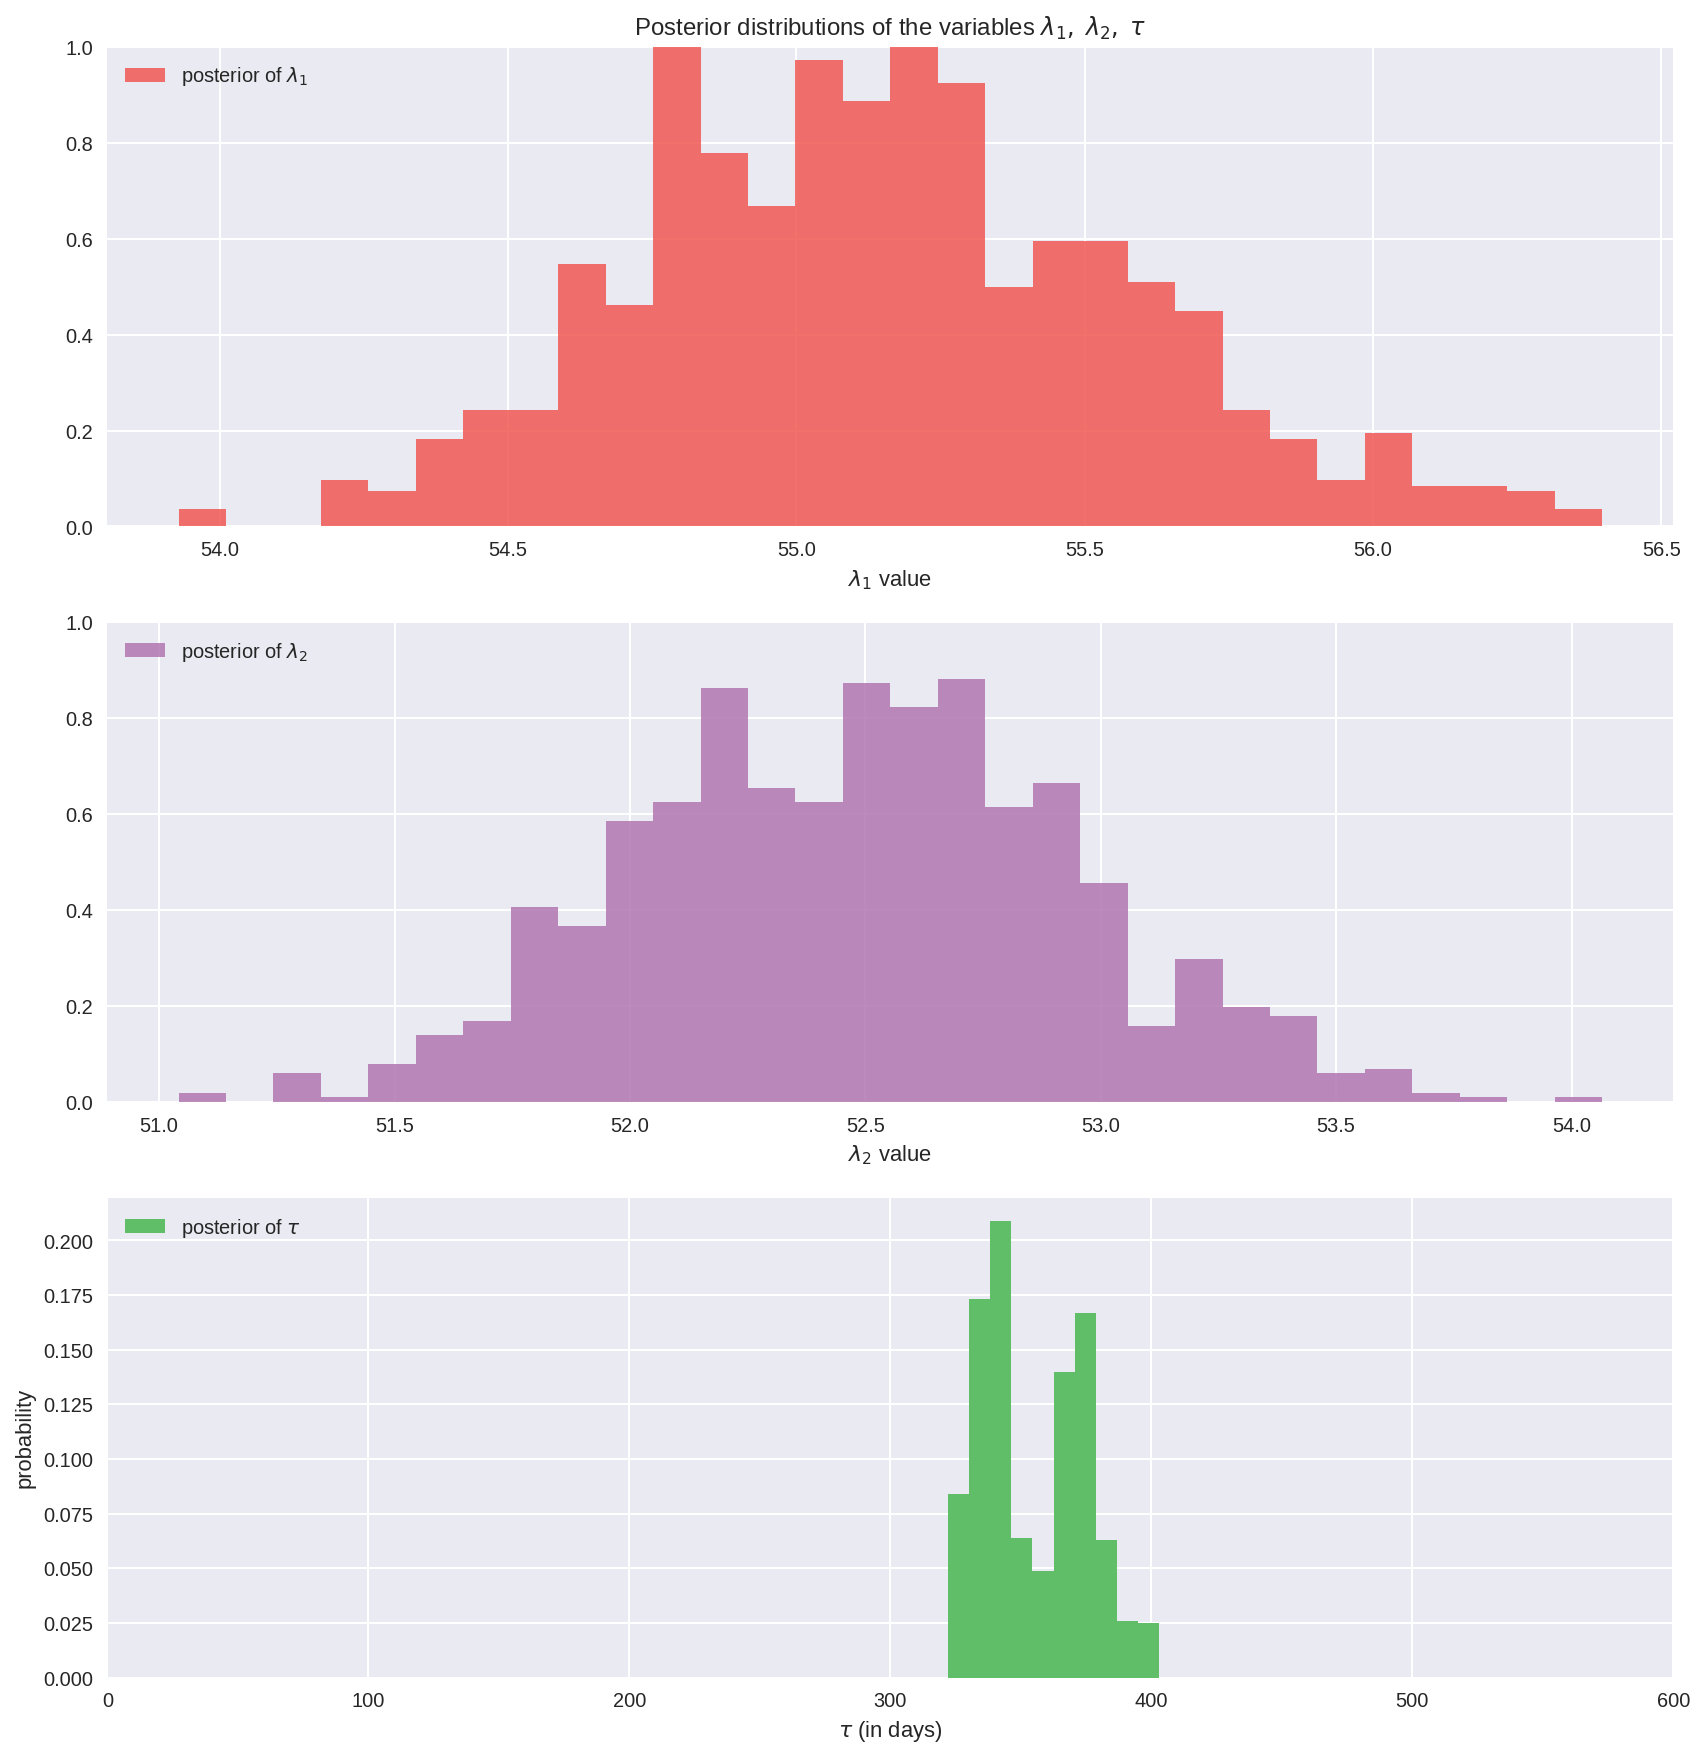

In [0]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:




ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel(r"$\lambda_1$ value")




ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda_2$ value")


plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=10, alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)

plt.legend(loc="upper left")
plt.xlim([0, data_.shape[0]])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability")

The following visualisation shows the varying rate of faulty products produced by the factory per day. Around 70% of all measurements are located in the blue area. You can clearly see the drop after around 360 days, which indicates the day of inspection.

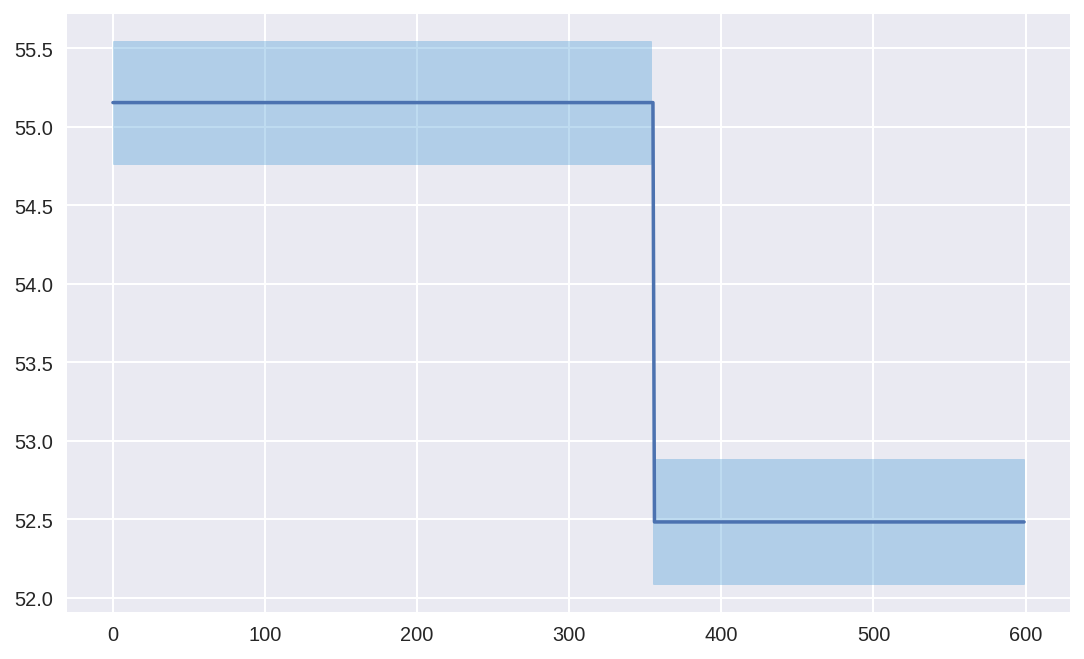

In [0]:
alpha = np.array(1. / data_.mean(), np.float32)
lambda_1 = lambda_1_samples_.mean()
lambda_1_std = lambda_1_samples_[-300:].std()

lambda_2 = lambda_2_samples_.mean()
lambda_2_std = lambda_2_samples_[-300:].std()

tau = tau_samples_.mean()

lambda_ = tf.gather(
     [lambda_1, lambda_2],
     indices=tf.cast(np.arange(data_.size) >= tau, dtype=tf.int32))

dist_samples_ = evaluate(lambda_)


X = np.arange(data_.shape[0])
plt.plot(X, dist_samples_)
plt.fill_between(X[:int(tau)], lambda_1 - lambda_1_std, lambda_1 + lambda_1_std, color=TFColor[3], alpha=0.4)
plt.fill_between(X[int(tau):], lambda_2 - lambda_2_std, lambda_2 + lambda_2_std, color=TFColor[3], alpha=0.4)
plt.show()